# Audio tone classification. 
dataset link: https://zenodo.org/record/1188976#.YpvStOxBxPa

In [2]:
from numpy import array
from numpy import hstack
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ReLU
from keras.layers import LeakyReLU
from keras.layers import Softmax
from tensorflow import keras
#from tensorflow.keras.optimizers import Adam
import csv
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.models import load_model
import numpy as np
from tensorflow import keras
import keras.optimizers
#from utils.openmax import image_show, compute_activation, compute_openmax
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from IPython.display import Audio 
from sklearn.metrics import confusion_matrix
#!pip install pydub
#from pydub import AudioSegment
import warnings
warnings.filterwarnings("ignore")

In [3]:
#read all file paths
path = 'audio_dataset'
files = [os.path.join(dirpath, f) for dirpath, dirnames, file in os.walk(path) for f in file if f.endswith('.wav')]
labels = [int(f.split('\\')[-1][6:8]) for f in files]

    

In [4]:
labels = [x-1 for x in labels]
labels_dict ={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}

In [35]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7}

# Generate data to avoid overfitting. one way to synthesize audio data is to add noise to the existing data. 

In [6]:
def noise(data,noise_factor=0.0005):
    noise = np.random.randn(len(data))
    data = data + noise_factor*noise
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)


# Extract features from he audio files. These features will be out input for the neural network 

In [16]:
def extract_feature(x,sr):
  # Code Here
    X=[] # feature vector

    #spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)
    #for i in spectral_centroids:
    #    X.extend([np.mean(i)])

    mfccs = librosa.feature.mfcc(x, sr=sr)
    for i in mfccs:
        X.extend([np.mean(i)])

    #chromagram = librosa.feature.chroma_stft(x, sr=sr)
    #for i in chromagram:
    #    X.extend([np.mean(i)])

    #mel = librosa.feature.melspectrogram(x, sr=sr)
    #for i in mel:
    #    X.extend([np.mean(i)])  
    return X

In [8]:
# extract all features(mel,chroma,spec_cen,mfcc) for train set
X=[]
for f in files:
    x,sr = librosa.load(f,duration=3, offset=0.5, res_type='kaiser_fast')  # read audio file
    x = extract_feature(x,sr)
    X.append(x)
X=np.array(X)
print(X.shape)

(1440, 20)


In [9]:


# ---------
X_noise = []
for f in files:
    x,sr = librosa.load(f,duration=3, offset=0.5, res_type='kaiser_fast')  # read audio file
    x = noise(x)
    x = extract_feature(x,sr)
    X_noise.append(x)
X_noise=np.array(X_noise)
print(X_noise.shape)
X = np.vstack((X, X_noise))
print(X.shape)
#-----------------------#
X_shift = []

for f in files:
    x,sr = librosa.load(f,duration=3, offset=0.5, res_type='kaiser_fast')  # read audio file
    x = shift(x)
    x = extract_feature(x,sr)
    X_shift.append(x)
X_shift=np.array(X_shift)
print(X_shift.shape)
X = np.vstack((X, X_shift))
print(X.shape)




labels = labels+labels+labels
len(labels)

(1440, 20)
(2880, 20)
(1440, 20)
(4320, 20)


4320

# Train test split for training, validation and testing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)  
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)  

# Convert labels

In [11]:
from keras.utils import np_utils
import tensorflow.keras as keras
num_classes = 8

In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# ReduceLROnPlateau modifies learning rate along the learning proess to better learn the parameters

In [13]:
from keras.callbacks import ReduceLROnPlateau
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.000001)

# Normalise using StandardScaler

In [14]:
# Normalisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
 
train_x = sc.fit_transform(X_train)
test_x = sc.transform(X_test)
val_x = sc.transform(X_val)



In [15]:
# save model for flask deployment
import pickle
pickle.dump(sc,open('sc.pkl','wb'))

# Create the model (cnn)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPool1D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv1D(50, strides=1, padding="same",  kernel_size=3,activation="relu", 
                 input_shape=(20,1, )))
model.add(BatchNormalization())
model.add(MaxPool1D(2, strides=2, padding="same"))
model.add(Conv1D(50, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool1D(2, strides=2, padding="same"))
model.add(Conv1D(25,  kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(2, strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 50)            200       
                                                                 
 batch_normalization (BatchN  (None, 20, 50)           200       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 50)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 50)            7550      
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 50)           2

In [17]:
model.compile(loss="categorical_crossentropy",optimizer='adam' ,metrics=["accuracy"])

In [18]:
model.fit(train_x, y_train, epochs=25, verbose=1, validation_data=(val_x, y_val), callbacks=[rlrp])

Epoch 1/25
110/110 [==============================] - 2s 9ms/step - loss: 1.8536 - accuracy: 0.2809 - val_loss: 2.0345 - val_accuracy: 0.1825 - lr: 0.0010
Epoch 2/25
110/110 [==============================] - 1s 6ms/step - loss: 1.5337 - accuracy: 0.4230 - val_loss: 1.8739 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 3/25
110/110 [==============================] - 1s 6ms/step - loss: 1.3601 - accuracy: 0.4861 - val_loss: 1.5977 - val_accuracy: 0.3907 - lr: 0.0010
Epoch 4/25
110/110 [==============================] - 1s 6ms/step - loss: 1.2621 - accuracy: 0.5324 - val_loss: 1.3004 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 5/25
110/110 [==============================] - 1s 6ms/step - loss: 1.1690 - accuracy: 0.5604 - val_loss: 1.0775 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 6/25
110/110 [==============================] - 1s 6ms/step - loss: 1.0902 - accuracy: 0.5970 - val_loss: 0.9900 - val_accuracy: 0.6530 - lr: 0.0010
Epoch 7/25
110/110 [==============================] - 1s 6ms/step - lo

In [19]:
loss, accuracy = model.evaluate(test_x, y_test)

14/14 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.7801


In [20]:
model.save('model_tone_classificatiom')

INFO:tensorflow:Assets written to: model_tone_classificatiom\assets


In [21]:
y_pred = model.predict(test_x)

In [22]:
y_sk = np.argmax(y_test, axis=1)
y_sk_p = np.argmax(y_pred, axis=1)

In [23]:
print('accuracy: ',accuracy_score(y_sk, y_sk_p))
 

accuracy:  0.7800925925925926


In [24]:
print('confusion matrix:\n',confusion_matrix(y_sk, y_sk_p))

confusion matrix:
 [[16  4  0  1  0  0  1  0]
 [ 9 51  2  2  0  2  0  0]
 [ 3  2 47  2  0  2  1  2]
 [ 2  2  3 39  1  0  1  0]
 [ 1  1  4  1 46  0  0  1]
 [ 1  1  3  4  0 43  0  6]
 [ 1  0  1  4  4  1 39  3]
 [ 0  1  5  4  1  3  2 56]]


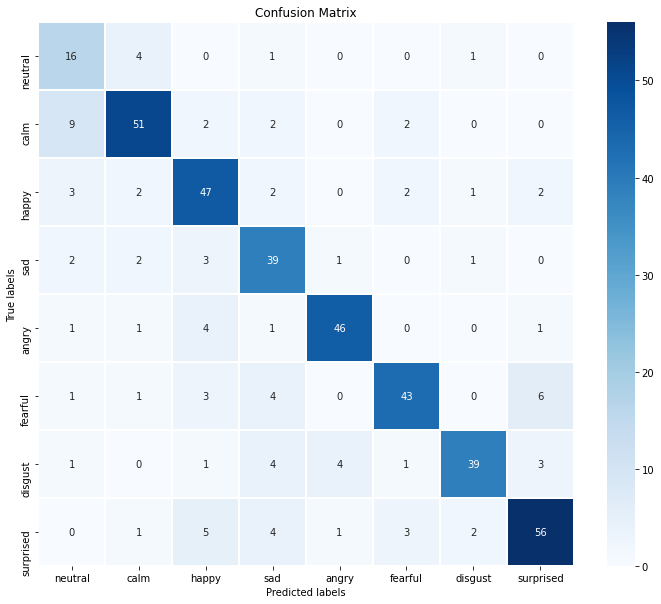

In [25]:
import seaborn as sns
plt.figure(figsize = (12, 10))
ax= plt.subplot()
cm = confusion_matrix(y_sk, y_sk_p)
#plt.figure(figsize = (12, 10))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels_dict.values()); ax.yaxis.set_ticklabels(labels_dict.values());

In [26]:
print(classification_report(y_sk, y_sk_p))

              precision    recall  f1-score   support

           0       0.48      0.73      0.58        22
           1       0.82      0.77      0.80        66
           2       0.72      0.80      0.76        59
           3       0.68      0.81      0.74        48
           4       0.88      0.85      0.87        54
           5       0.84      0.74      0.79        58
           6       0.89      0.74      0.80        53
           7       0.82      0.78      0.80        72

    accuracy                           0.78       432
   macro avg       0.77      0.78      0.77       432
weighted avg       0.79      0.78      0.78       432



# Ignore below. Used for testing

In [ ]:
!pip install sounddevice --user

In [1]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = 3  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file

In [3]:
import soundfile as sf
data, fs = sf.read('output.wav', dtype='float32')  
sd.play(data, fs)
status = sd.wait()

In [29]:
x_t,sr_t = librosa.load('output.wav',duration=3, offset=0, res_type='kaiser_fast')  # read audio file
x_t = extract_feature(x_t,sr_t)
x_t =np.array(x_t)

In [30]:
x_t = sc.transform(x_t.reshape(1, -1))

In [31]:
labels_dict.get(np.argmax(model.predict(x_t)))

'angry'

In [444]:
labels_dict.values()

dict_values(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])

In [37]:
model = keras.models.load_model('model_sentiment')

In [4]:
from scipy.io import wavfile
samplerate, data = wavfile.read('output.wav')

In [5]:
import librosa

In [11]:
x_t,sr_t = librosa.load('output.wav')

In [9]:
data

array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
       -1.3183594e-02, -1.1779785e-02, -9.7656250e-03], dtype=float32)

In [12]:
x_t

array([ 8.7598950e-05, -1.3553095e-04,  1.5723029e-04, ...,
       -9.8034916e-03, -1.1260131e-02, -1.2469493e-02], dtype=float32)

In [13]:
sr_t

22050

In [14]:
samplerate

44100

In [19]:
extract_feature(x_t,sr_t)

<ipython-input-16-a486dfdabb6f>:9: FutureWarning: Pass y=[ 8.7598950e-05 -1.3553095e-04  1.5723029e-04 ... -9.8034916e-03
 -1.1260131e-02 -1.2469493e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


[-345.23215,
 83.722824,
 5.748955,
 24.598495,
 14.039787,
 7.680853,
 -2.8926346,
 10.832621,
 -3.58919,
 3.4017067,
 -3.6498013,
 6.2617674,
 -2.4482684,
 0.83874935,
 -0.07216997,
 2.8990998,
 -0.9591049,
 1.5652184,
 -1.2807028,
 3.4452858]

In [18]:
import numpy as np

In [20]:
extract_feature(data,samplerate)

<ipython-input-16-a486dfdabb6f>:9: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ... -1.3183594e-02
 -1.1779785e-02 -9.7656250e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


[-371.99457,
 94.94758,
 9.173326,
 19.765842,
 13.811482,
 16.773241,
 2.2917209,
 0.8397733,
 5.062773,
 4.2629657,
 -1.8597373,
 1.066359,
 -1.6720636,
 2.8035917,
 0.9441455,
 -1.1549221,
 -1.5624036,
 2.776723,
 -1.6407391,
 1.640337]

In [29]:
from python_speech_features import mfcc
from python_speech_features import delta
np.mean((delta(mfcc(data,samplerate),2)))

0.010417579245709765

In [22]:
!pip install python_speech_features

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5893 sha256=e0b7aa9760620bbb1da6880c251745d7ca27904c99d5d4da5faf84463a5fcf04
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\5b\60\87\28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
